In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Photometry
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [51]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0)

In [41]:
phot = Photometry(wv,fl, np.ones_like(wv),203)

In [76]:
def Magnitude(wv,flam):
    fnu = (wv**2 / 3E18) * flam
    return -2.5*np.log10(fnu) - 48.6

In [95]:
np.arange(9.5,11,.1)

array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5,
       10.6, 10.7, 10.8, 10.9])

In [212]:
lmass_range = np.arange(9.5,10.9,.05)
# maglimit = []
zlimit = []
iZprior = interp1d(Mmn,np.log10(Smooth(Mmn,Zmean,0.5)), bounds_error=False, fill_value=-0.25)

for set_lmass in lmass_range:
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = iZprior(set_lmass))
    idx = 0
    mag = 100
    z = 2.8

    rshifts = []
    mags = []
    while z > 0.7:
        z -= 0.05

        wv,fl = sp.get_spectrum(tage = cosmo.age(z).value - cosmo.age(6).value,peraa=True,)
    #     flam = F_lam_per_M(fl, wv*(1 + z), z, 0, sp.stellar_mass)*10**set_lmass
        flam = F_lam_per_M(fl, wv*(1 + z), z, 0, 1)*10**set_lmass

        phot = Photometry(wv*(1 + z),flam, np.ones_like(wv),203)
        phot.Get_Sensitivity()
        phot.Photo()
        mag = Magnitude(phot.eff_wv,phot.photo)
        rshifts.append(z)
        mags.append(mag)

        idx+=1

        if mag < 24.5:
            break
        
    zlimit.append(interp1d(mags,rshifts)(25))


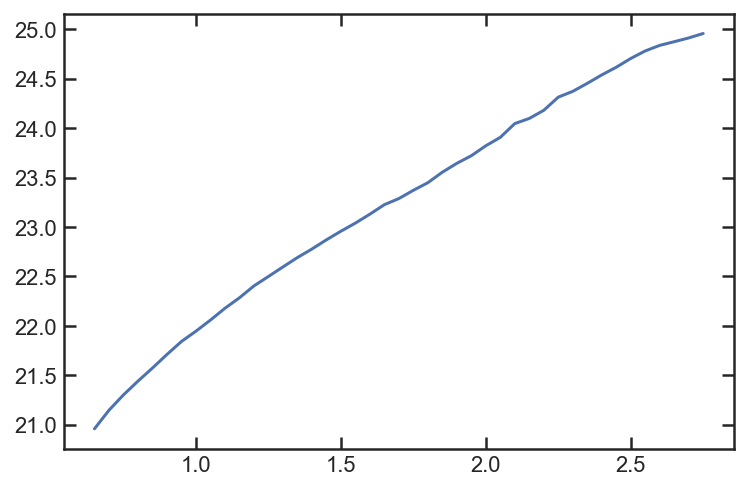

In [128]:
plt.plot(rshifts,mags)

# interp1d(mags,rshifts)(25)

In [58]:
sp.get_mags(bands =['wfc3_ir_f125w'], redshift = 5, tage =cosmo.age(z).value - cosmo.age(6).value)[0]

57.66128954513233

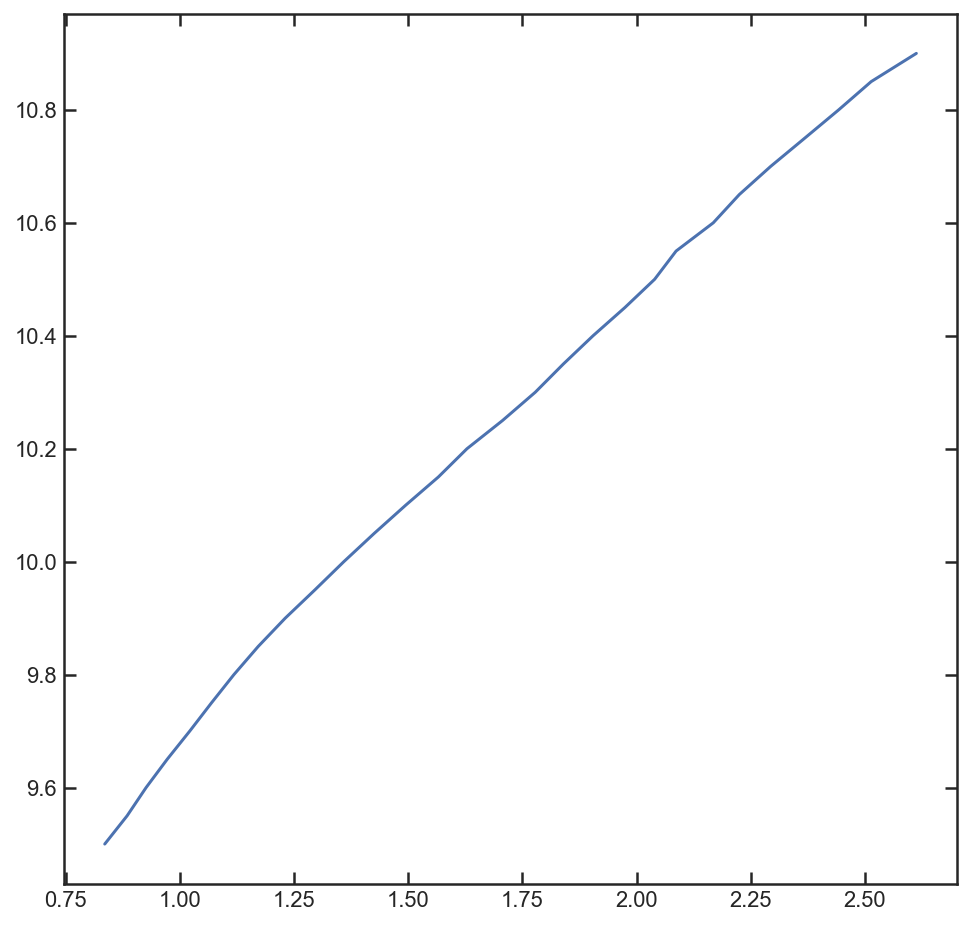

In [214]:
plt.figure(figsize=[8,8])
plt.plot(zlimit,lmass_range)
# plt.axis([0.5,2.5,9.5,11.5])

In [216]:
np.save('../data/masslimit',[zlimit,lmass_range])

In [191]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0)
set_lmass = 9.5

idx = 0
mag = 100
z = 2.8

rshifts = []
mags = []
while z > 0.7:
    z -= 0.05

    wv,fl = sp.get_spectrum(tage = cosmo.age(z).value - cosmo.age(6).value,peraa=True,)
#     flam = F_lam_per_M(fl, wv*(1 + z), z, 0, sp.stellar_mass)*10**set_lmass
    flam = F_lam_per_M(fl, wv*(1 + z), z, 0, 1)*10**set_lmass

    phot = Photometry(wv*(1 + z),flam, np.ones_like(wv),203)
    phot.Get_Sensitivity()
    phot.Photo()
    mag = Magnitude(phot.eff_wv,phot.photo)
    rshifts.append(z)
    mags.append(mag)

    idx+=1
    
    if mag < 24.5:
        break

(28.5, 24.5)

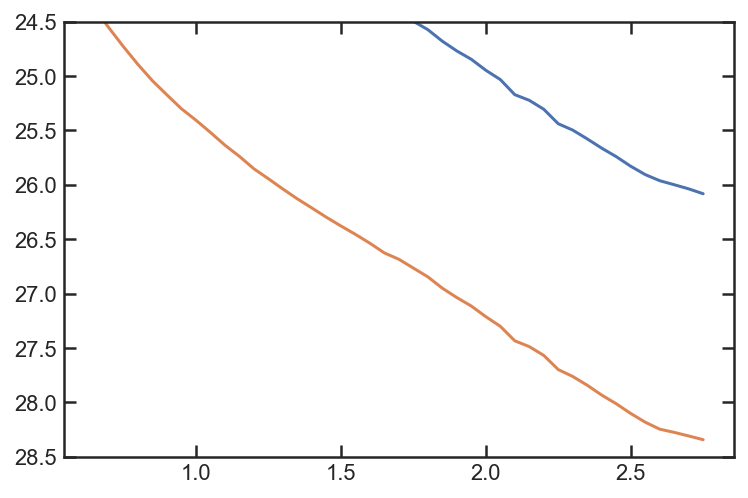

In [190]:
plt.plot(rshifts,mags)
plt.plot(rshifts2,mags2)

plt.ylim(28.5,24.5)

In [200]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i"')

mdbmin = morph_db.query('n_f < 2')
# mdbmin = morph_db.query('zgrism > 0.8')

mdb = morph_db.query('n_f < 2 and zgrism > 0.7')


In [179]:
def Roll_bin_stat(X,Y,E,bin_size):
    W = 1/E ** 2
    Y = Y[np.argsort(X)]
    W = W[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_median = [] ; binned_wmean = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        binned_median.append(np.median(Y[IDX]))
        binned_wmean.append(np.sum(Y[IDX] * Y[IDX]) / (np.sum(Y[IDX])))

        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_median), np.array(binned_wmean)

def Smooth(x,f,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

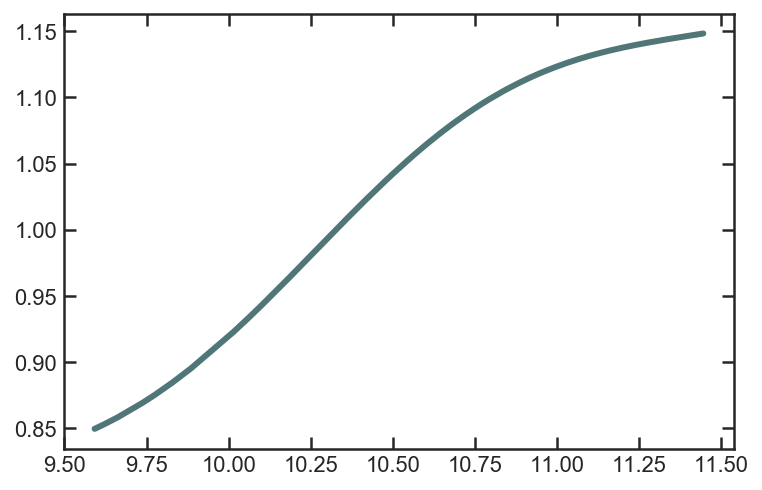

In [180]:
Mmd, Mmn, Zmedian, Zmean, = Roll_bin_stat(np.array(lm), np.array(fz), np.array(errs),.1)
plt.plot(Mmn,Smooth(Mmn,Zmean,0.5), linewidth=3, color='#507678')

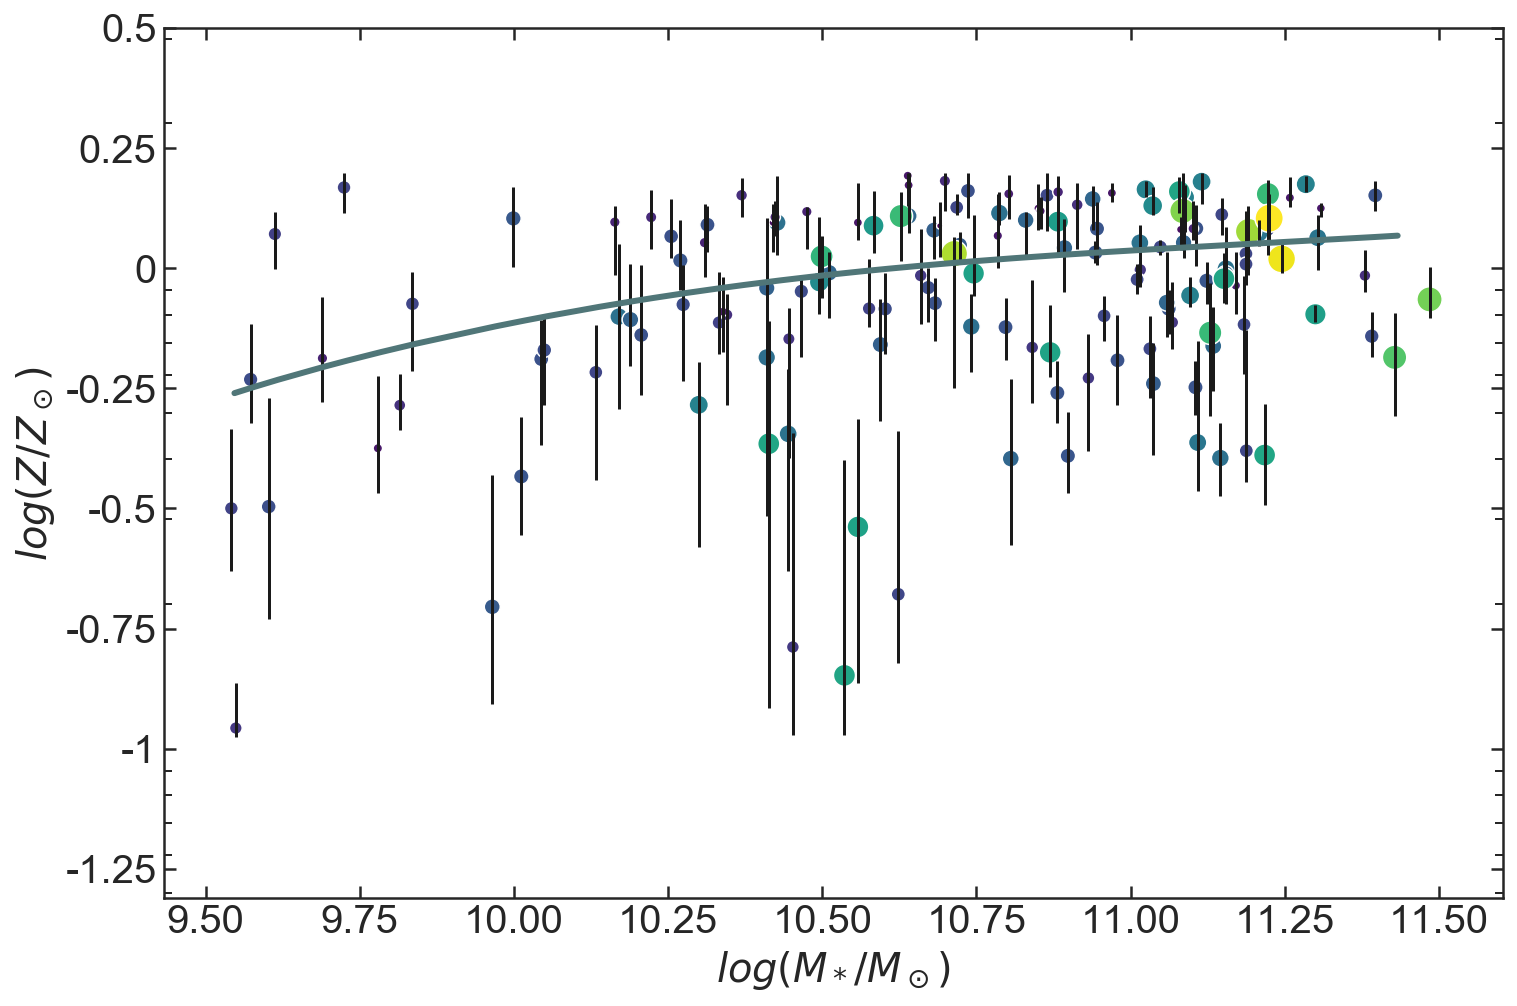

In [201]:
fig = plt.figure(figsize=[12,8])
ax = plt.subplot()

rl = []
rh = []
fz = []
lm = []
zg = []

for i in morph_db.index:
    for ii in range(len(morph_db.Z_hci[i])//2):
        if morph_db.Z_hci[i][2*ii] <= morph_db.Z[i] <= morph_db.Z_hci[i][2*ii+1]:
            ax.errorbar(morph_db.lmass[i],morph_db.Z[i], 
                 yerr=[[morph_db.Z[i] - morph_db.Z_hci[i][2*ii]], [morph_db.Z_hci[i][2*ii+1] - morph_db.Z[i]]], fmt='k', markersize=0)
            rl.append(morph_db.Z[i] - morph_db.Z_hci[i][2*ii])
            rh.append(morph_db.Z_hci[i][2*ii+1] - morph_db.Z[i])
            fz.append(morph_db.Z[i])
            lm.append(morph_db.lmass[i])
            zg.append(morph_db.zgrism[i])
            
ax.set_ylim(10**-1.31,10**.5)

sea.scatterplot(lm, fz,hue=zg, size=zg,
                     palette='viridis', sizes=(10, 200),legend=False, ax=ax)


rl = np.array(rl)
rh = np.array(rh)
fz = np.array(fz)
       
errs = ((rl - rh)/2) / (fz*np.log(10))
samp = np.arange(9.5,11.5,.01)
lfit,lfit_errs,cov = Linear_fit(lm, np.log10(fz) , errs, samp, return_cov=True)

# plt.plot(samp,10**lfit,'k',linewidth=2,label ='Best Fit Line')
# plt.fill_between(samp,10**(lfit - lfit_errs),10**(lfit + lfit_errs),alpha = .2,label = '68% Conifidence Interval')

Mmd, Mmn, Zmedian, Zmean, = Roll_bin_stat(np.array(lm), np.array(fz), np.array(errs),.01)
# plt.plot(Mmn, Zmean)
plt.plot(Mmn,Smooth(Mmn,Zmean,0.5), linewidth=3, color='#507678')

plt.yscale('log')
plt.yticks(10**np.array([-1.25,-1,-0.75,-.5,-.25,0,0.25,0.5]),[-1.25,-1,-0.75,-.5,-.25,0,0.25,0.5])



plt.xlabel('$log(M_*/M_\odot)$', fontsize=20)
plt.ylabel('$log(Z/Z_\odot)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)



In [209]:
iZprior = interp1d(Mmn,np.log10(Smooth(Mmn,Zmean,0.5)), bounds_error=False, fill_value=-0.25)

In [211]:
iZprior(9.5)

array(-0.25)